# Bias correction with linear regression

**Authors**: [Matthew Chantry](https://www.ecmwf.int/en/about/who-we-are/staff-profiles/matthew-chantry) and [Fenwick Cooper](https://www.physics.ox.ac.uk/our-people/cooperf)

*This notebook was last tested and operational on 01/10/2025. Please [report any issues](https://github.com/ecmwf-training/ml-examples/issues).*

:::{admonition} About
:class: note, dropdown
This notebook was originally created for ECMWF's [MOOC on Machine Learning in Weather and Climate](https://learning.ecmwf.int/course/index.php?categoryid=1), and has been lightly updated and tested for the purposes of this collection of examples. The original notebook can be found [here](https://github.com/ecmwf-training/mooc-machine-learning-weather-climate/blob/main/tier_2/regression_decision_trees/linear_regression.ipynb).

This example of using machine learning to model weather forecast error based on work by Fenwick Cooper funded by <a href="https://www.ifabfoundation.org/">IFAB</a>, the full study can be found <a href="https://www.ecmwf.int/en/elibrary/81297-statistical-modelling-2m-temperature-and-10m-wind-speed-forecast-errors">here</a>.
:::

:::{admonition} Running this notebook
:class: tip, dropdown
This notebook can be run/accessed on the following free online platforms. Please note they are not officially supported by or linked with ECMWF. See [Running the notebooks](sec:running_notebooks) for more details.

[![colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ecmwf-training/ml-examples/blob/develop/ex_Linear_Regression_Postprocessing.ipynb)
[![kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/ecmwf-training/ml-examples/blob/develop/ex_Linear_Regression_Postprocessing.ipynb)
[![binder](https://mybinder.org/badge.svg)](https://mybinder.org/v2/gh/ecmwf-training/ml-examples/develop?labpath=ex_Linear_Regression_Postprocessing.ipynb)
[![github](https://img.shields.io/badge/Open%20in-GitHub-black?logo=github)](https://github.com/ecmwf-training/ml-examples/blob/develop/ex_Linear_Regression_Postprocessing.ipynb)

:::

## Introduction

In this example we will apply linear regression to the ECMWF forecast of surface temperature. Specifically, we are trying to predict the difference between station observations of 2m-temperature and the corresponding forecast prediction at the nearest gridpoint to the observation location. If we can accurately predict this difference (the forecast error) we can compensate for it, making the forecast more accurate. This type of approach is called *bias correction*, which is a form of statistical post-processing.

Linear regression can be a powerful tool for model building. Even in cases where it does not produce the most accurate model, it is easy to interpret the decisions it has made. Here, we use linear regression of nonlinear features to model the problem. We still solve a least-squares problem to find the best fitting linear model, but we include powers of the predictors as inputs.
e.g. instead of building $y = a + bx$ we can learn $y = a + bx + cx^2 + dx^3$.

We will explore several physically-motivated predictors. The choice of which powers or combinations of features to use could be informed by our physical understanding of the problem.

The steps we will follow are:

1. Download a dataset of forecast errors and corresponding possible explanatory variables (soil temperature and time of day).
2. Split data into training and testing sets.
3. Build cubic polynomial models using one or two predictors.
4. Evaluate the performance of the models.

## Prepare your environment

The following packages are used to process and model the data:

- numpy for handling arrays and mathematical functions
- sklearn for machine learning tools
- matplotlib for plots

In [1]:
# First import the tools we will use. Where possible it is always worth using
# existing tools, even if the mathematics are simple to write down yourself.
import numpy as np
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
import matplotlib.pyplot as plt

Before going further, we also have to download a utility function for plotting. This is contained within a [plugin](https://github.com/mchantry/climetlab-mltc-surface-observation-postprocessing) to the [Climetlab](https://climetlab.readthedocs.io/en/latest/) package, which is no longer updated. In order to avoid a dependency on this package (which can cause errors in some environments), we load the function directly from the GitHub source code.

In [17]:
# Download the raw Python file from GitHub
!wget -O utils.py https://raw.githubusercontent.com/mchantry/climetlab-mltc-surface-observation-postprocessing/master/climetlab_mltc_surface_observation_postprocessing/utils.py

# Run it in the notebook so functions are available
%run utils.py

--2025-10-01 13:42:10--  https://raw.githubusercontent.com/mchantry/climetlab-mltc-surface-observation-postprocessing/master/climetlab_mltc_surface_observation_postprocessing/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2451 (2.4K) [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]   2.39K  --.-KB/s    in 0s      

2025-10-01 13:42:10 (30.8 MB/s) - ‘utils.py’ saved [2451/2451]



## Load data

We will now download the dataset: this comprises 36-hour forecast errors of 2m-temperature from a ECMWF's high resolution forecast system, using station observations as the truth. Currently there are three variables in the dataset:

- `forecast_error`: the difference between the forecasted value of 2m-temperature and the observed value, in °C.
- `time_of_day`: the local time of day, in decimal hours. Useful for diagnosing the diurnal cycle model bias.
- `soil_temperature`: the model soil temperature, in °C.

For each variable, the dataset contains over 5 million datapoints covering around 8000 weather stations around the world (not specified in the dataset).

We will load each variable separately, reshaping them for compatability with scikit-learn.

In [9]:
base_url = "https://object-store.os-api.cci1.ecmwf.int/sop/"

# load in variables one at a time (.reshape() puts in correct format for later)
forecast_error = np.genfromtxt(base_url + "forecast_error.csv", delimiter=",", skip_header=1).reshape(-1, 1)
soil_temperature = np.genfromtxt(base_url + "soil_temperature.csv", delimiter=",", skip_header=1).reshape(-1, 1)
time_of_day = np.genfromtxt(base_url + "time_of_day.csv", delimiter=",", skip_header=1).reshape(-1, 1)

Note that an important step of data preprocessing has already been carried out in the curation of the dataset. Spurious data has already been removed from the dataset based upon a range of categories, e.g. stations with inconsistent measurement locations, repeated values, or even physically  invalid numbers (>100°C). If you are starting on a new project this is a key step to clean the data.

## Prepare data

Now we can prepare the data for our model. This involves randomly splitting the data into training and testing sets, such that 80% of the data is in the training set and 20% in the testing set.

Ideally, we would like to know the geospatial location and time of our data points, because this would allow us to design our training/test sets to ensure independence (for more info, see our [ML MOOC](https://learning.ecmwf.int/course/index.php?categoryid=1)). However, we don't have this information, so random sampling will be used. We will also not create a validation set because we are not exploring a hyperparameter space.

The splitting into training and test sets can be done one in one call to the `train_test_split()` function of scikit-learn.

In [10]:
(forecast_error_train, forecast_error_test,
    time_of_day_train, time_of_day_test,
    soil_temperature_train,  soil_temperature_test) = train_test_split(forecast_error, #the variables to split
                                                                       time_of_day,
                                                                       soil_temperature,
                                                                       test_size = 0.2, #what proportion of the data to use in the test set
                                                                       random_state = 42, #set the random seed for reproducibility
                                                                      )

## Build model

Our first model will be a cubic polynomial, which regresses the forecast error onto the time of day. This is a simple univariate regression. To do this we'll first create an array with the linear, quadratic and cubic terms.

In [11]:
# Create the predictor data
X = np.concatenate([time_of_day_train, time_of_day_train**2, time_of_day_train**3],axis=-1)

Next we will create the model object, and fit it to the data. Recall that although as a cubic polynomial, $y$ (forecast error) can be nonlinear with respect to $x$ (time of day), the regression is still linear with respect to its parameters. Another way of looking at this is that we are fitting a model $y = a + bx_1 + cx_2 + dx_3$, where $x_1 = x$, $x_2 = x^2$ and $x_3 = x^3$. We have created the quadratic and cubic terms before feeding them into the model - the model only "sees" a linear regression on three variables. It doesn't "know" that they are quadratic and cubic transformations of the same variable.

In [12]:
# Create linear regression object
reg = linear_model.LinearRegression()

# Train the model using the data.
# We task it to find the best fit for the forecast errors given a cubic relationship.
reg.fit(X, forecast_error_train)

LinearRegression()

The model is now fitted. We will evaluate our model using root-mean-squared error (RMSE) and mean-absolute error (MAE). However we want to begin by calculating the RMSE and MAE of the existing forecasts. To do this, we compare the forecast errors with a vector of zeroes (zero being no error). The idea will be to see whether our cubic model can improve on these scores.

In [13]:
# To establish a baseline let's find out the RMSE and MAE of the existing predictions.
# Our baseline is no error correction, or a correction of 0.
zero_test = 0.0*forecast_error_test

baseline_mae = metrics.mean_absolute_error(zero_test, forecast_error_test)
baseline_rmse = np.sqrt(metrics.mean_squared_error(zero_test, forecast_error_test))
print('Mean Absolute Error Uncorrected:', baseline_mae)
print('Root Mean Squared Error Uncorrected:', baseline_rmse)

Mean Absolute Error Uncorrected: 1.6323756023379807
Root Mean Squared Error Uncorrected: 2.2561352539787456


Can our cubic model improve this? To find out, we will generate error predictions at the times of day used in the test data, and compare with the corresponding observed errors, obtaining new RMSE and MAE values. If these MAE and RMSE are less than the baseline values, this implies that the cubic model would be able to improve the forecasts (by subtracting the resulting errors).

In [14]:
# Build our input array, then make a prediction with our model
X_test = np.concatenate([time_of_day_test, time_of_day_test**2, time_of_day_test**3],axis=-1)

forecast_corrected = reg.predict(X_test)

corrected_mae = metrics.mean_absolute_error(forecast_error_test, forecast_corrected)
corrected_rmse = np.sqrt(metrics.mean_squared_error(forecast_error_test, forecast_corrected))

print('Mean Absolute Error Corrected:', corrected_mae)
print('Root Mean Squared Error Corrected:', corrected_rmse)

print('% Improvement MAE over raw forecast', -(corrected_mae - baseline_mae)/baseline_mae * 100 )
print('% Improvement RMSE over raw forecast', -(corrected_rmse - baseline_rmse)/baseline_rmse * 100 )


Mean Absolute Error Corrected: 1.5965240993023346
Root Mean Squared Error Corrected: 2.220606877395627
% Improvement MAE over raw forecast 2.196277804219663
% Improvement RMSE over raw forecast 1.5747449768564892


This shows that we would get a 1-2% improvement if we were to use the cubic model based on time of day to correct the forecast bias.

As a final step in this part we will visualise the model predicted errors against the observed errors. We'll do this by both extracting the coefficients of the regression model and manually creating a prediction, and using the `predict` method of our regression model, to show two alternative possibilities.

In [15]:
# Extract the coefficients from the regression model and
# rename the coefficients found by the fit
c0 = reg.intercept_
c1 = reg.coef_[0][0]
c2 = reg.coef_[0][1]
c3 = reg.coef_[0][2]

# Make a line of best fit for plotting
x = np.linspace(0, 24, 49)

# Predictions at x (manual encoding)
y = c0 + c1 * x + c2 * x**2 + c3 * x**3

# or equivalently use the our regression object directly (overwrites previous)
x_stack = np.stack([x,x**2,x**3],axis=-1)
y = reg.predict(x_stack)

Now we plot the model error predictions and the observed predictions from the test set against time of day. Because the number of observations is quite large (about one million), we will not plot the observed predictions as individual points, but instead generate a density map using the `imgBufferFromVectors()` function. We'll then overlay our fitted line.

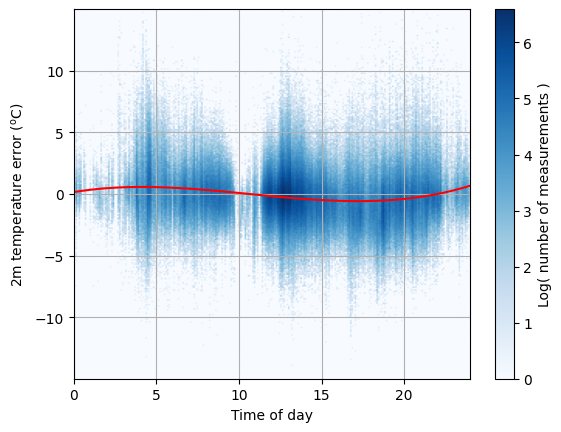

In [19]:
# Make an image of the time of day against the forecast error.
# This function helps us build an image of the results
tod_buffer, ax_extent, count = imgBufferFromVectors(time_of_day_test, forecast_error_test,
                                                    nx=256, ny=256, extent=[],
                                                    calc_average=False)

# Plot the number of measurements at each time of day and forecast error
plt.imshow(np.log((count==0.0)+count),
           cmap='Blues', origin='lower',
           extent=ax_extent, aspect='auto')

plt.xlim([0, 24])
plt.grid()
plt.xlabel('Time of day')
plt.ylabel(r'2m temperature error ($^\mathrm{o}$C)')
cb = plt.colorbar()
cb.set_label('Log( number of measurements )')

# Line of best fit
plt.plot(x,y,'red')

plt.show()

This plot is revealing. Although the model (red line) is better than nothing (and does indeed have the potential to improve our forecasts slightly), there is a huge amount of variation which is *not* explained. Indeed, the error only seems to have a weak relationship with respect to the time of day.

We could use a neural network or other machine learning methods to find the red line instead, but no model can account for all of the 2m temperature error with only this single predictor.

How can we improve the results? Let's test whether another predictor can help. We will try using the soil temperature.

## Adding more predictors

Next we will add a second predictor, the model soil temperature. Let's look at how the forecast error varies with these predictors to understand how well we might expect our model to perform.

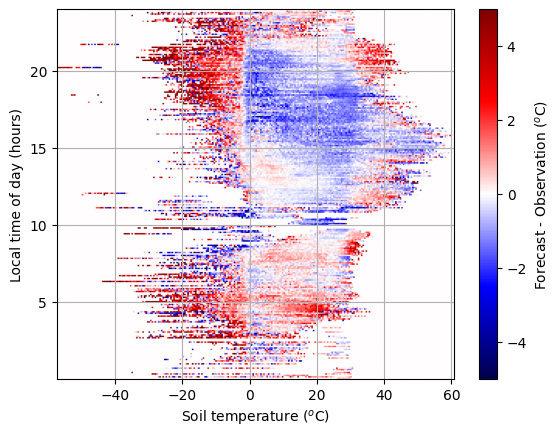

In [20]:
# Make image of the error with the new predictor
buffer, ax_extent, count = imgBufferFromVectors(soil_temperature_test,
                                                time_of_day_test,
                                                forecast_error_test,
                                                256, 256,
                                                extent = [],
                                                calc_average=True)

# Plot the image of the error
plt.imshow(buffer, vmin=-5, vmax=5, cmap='seismic', origin='lower',
           extent=ax_extent, aspect='auto')

plt.grid()
plt.xlabel('Soil temperature ($^o$C)')
plt.ylabel("Local time of day (hours)")
cb = plt.colorbar()
cb.set_label('Forecast - Observation ($^o$C)')

plt.show()

This plot is a heatmap of the forecast error (represented by the colour bar), plotted against the soil temperature and time of day (x and y axes, respectively). We see that forecast errors vary with both of these predictors, so we can expect our model to improve if we add soil temperature as a predictor. It also appears that there is a more discernable pattern in the forecast error, and this implies that it might more be more feasible to model it.

Based on experience, we will also create a third training variable, which encodes whether the soil is frozen or not. This is created from the soil temperature.

In [21]:
# To help the model learn we will create an extra feature to highlight that 0C carries importance.

# Where the soil is frozen (1) or not (0)
soil_frozen_train = soil_temperature_train < 0.0

We'll now write a function to create and concatenate polynomial terms for these three variables. It will be used more than once and avoids repetition.

In [22]:
def build_cubic_predictor_array(time_of_day,soil_temperature,soil_frozen):
  X = np.concatenate([
      # Linear terms
              time_of_day, soil_temperature, soil_frozen,
              # Quadratic terms
              time_of_day**2,
              time_of_day * soil_temperature,
              time_of_day * soil_frozen,
              soil_temperature**2,
              soil_temperature * soil_frozen,
              # soil_frozen**2 == 1, so we leave out
              # Cubic terms
              time_of_day**3,
              time_of_day**2 * soil_temperature,
              time_of_day**2 * soil_frozen,
              time_of_day    * soil_temperature**2,
              time_of_day    * soil_temperature * soil_frozen,
              soil_temperature**3,
              soil_temperature**2 * soil_frozen,
              ],axis=-1)
  return X


Time to fit the new model. We create the predictor array, then fit the cubic model to the training data. Recall that this model has linear, quadratic and cubic terms for each of the three variables: soil temperature, time of day, and the frozen soil variable.

In [23]:
%%time
# Fit a cubic polynomial using scikit-learn

# Create the data using a cubic polynomial.
# (Note that soil_frozen**2 == soil_frozen.)
X = build_cubic_predictor_array(time_of_day_train, soil_temperature_train, soil_frozen_train)

# Create linear regression object
reg = linear_model.LinearRegression()

# Train the model using the train sets
reg.fit(X, forecast_error_train)

CPU times: user 4.13 s, sys: 475 ms, total: 4.61 s
Wall time: 4.73 s


LinearRegression()

We want to evaluate the performance of our new model. To do so, we follow the same procedure as previously: we generate predictions at the points in the test dataset, and compare the error of the cubic model with the error with respect to the zero baseline.

In [24]:
# Calculate Root Mean Square error of predictions:

zero_test = 0.0*forecast_error_test
print('Mean Absolute Error Uncorrected:', metrics.mean_absolute_error(zero_test, forecast_error_test))
print('Root Mean Squared Error Uncorrected:', np.sqrt(metrics.mean_squared_error(zero_test, forecast_error_test)))

#Now apply forecast error correction:
soil_frozen_test = soil_temperature_test < 0.0      # Where the soil is frozen (1) or not (0)

X_test = build_cubic_predictor_array(time_of_day_test, soil_temperature_test, soil_frozen_test)

forecast_corrected = reg.predict(X_test)

##forecast_corrected = linear_model.predict(X_apply)
corrected_mae = metrics.mean_absolute_error(forecast_error_test, forecast_corrected)
corrected_rmse = np.sqrt(metrics.mean_squared_error(forecast_error_test, forecast_corrected))

print('Mean Absolute Error Corrected:', corrected_mae)
print('Root Mean Squared Error Corrected:', corrected_rmse)

print('% Improvement MAE over raw forecast', -(corrected_mae - baseline_mae)/baseline_mae * 100 )
print('% Improvement RMSE over raw forecast', -(corrected_rmse - baseline_rmse)/baseline_rmse * 100 )



Mean Absolute Error Uncorrected: 1.6323756023379807
Root Mean Squared Error Uncorrected: 2.2561352539787456
Mean Absolute Error Corrected: 1.5789160602216876
Root Mean Squared Error Corrected: 2.190468419221281
% Improvement MAE over raw forecast 3.274953511907758
% Improvement RMSE over raw forecast 2.9105894534319146


We see an improvement of about ~3% just from using these two predictors. We'll also visualise the results - to do so we have to generate a grid of points over the domain and generate model predictions at those points.

In [25]:
# Run the fit model over the plot domain

# The x and y values of each point in the plot image
nx = buffer.shape[0]
ny = buffer.shape[1]
x_st = np.linspace(ax_extent[0],ax_extent[1],nx)  # Represents soil_temperature
y_tod = np.linspace(ax_extent[2],ax_extent[3],ny)  # Represents time_of_day

# These lines
x_mesh = np.meshgrid(y_tod,x_st,indexing='ij')
tod_test = x_mesh[0].reshape((-1,1))
soil_test = x_mesh[1].reshape((-1,1))
frozen_test = soil_test < 0.0

X_plot = build_cubic_predictor_array(tod_test,soil_test,frozen_test)

model_buffer = reg.predict(X_plot).reshape(buffer.shape)

We now generate the plots. We'll plot:

1. The observed forecast errors (as plotted previously).
2. The model-predicted forecast errors, at the points in the test set.
3. The model-predicted forecast errors over the whole domain.

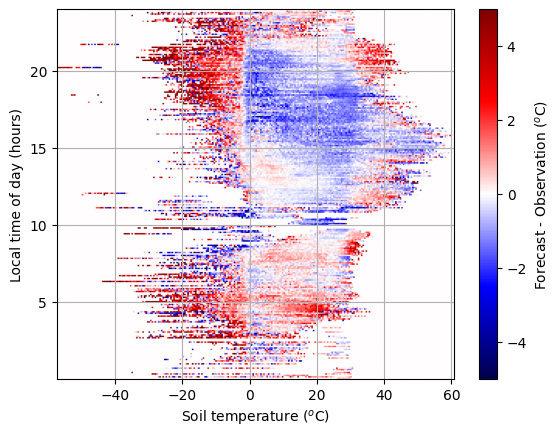

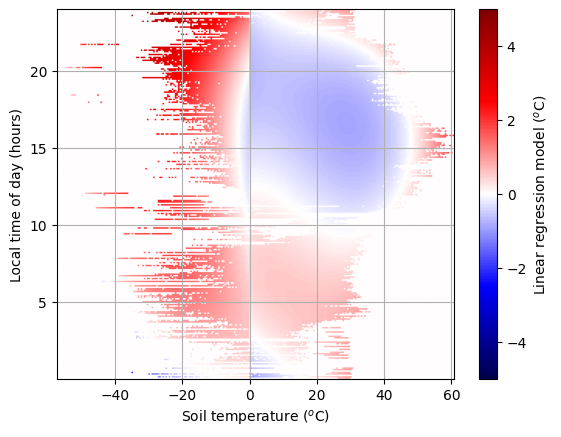

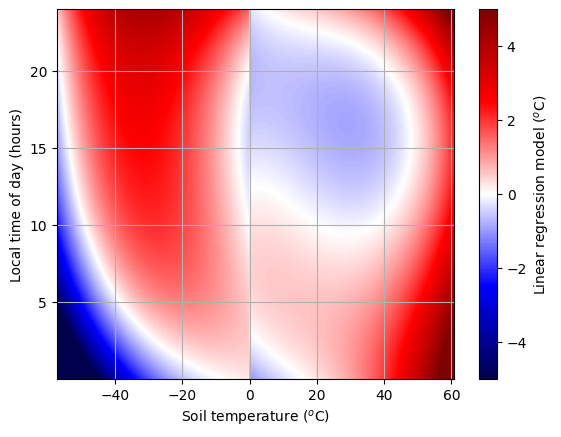

In [26]:
# Plot the image of the error
plt.imshow(buffer, vmin=-5, vmax=5, cmap='seismic', origin='lower',
           extent=ax_extent, aspect='auto')

plt.grid()
plt.xlabel('Soil temperature ($^o$C)')
plt.ylabel("Local time of day (hours)")
cb = plt.colorbar()
cb.set_label('Forecast - Observation ($^o$C)')

plt.show()

# Plot the model, only over the points where there is data in the test set.
plt.imshow((model_buffer)*(count>0), vmin=-5, vmax=5, cmap='seismic', origin='lower',
           extent=ax_extent, aspect='auto')

plt.grid()
plt.xlabel('Soil temperature ($^o$C)')
plt.ylabel("Local time of day (hours)")
cb = plt.colorbar()
cb.set_label('Linear regression model ($^o$C)')

plt.show()

# Plot the model over the whole domain
plt.imshow(model_buffer, vmin=-5, vmax=5, cmap='seismic', origin='lower',
           extent=ax_extent, aspect='auto')

plt.grid()
plt.xlabel('Soil temperature ($^o$C)')
plt.ylabel("Local time of day (hours)")
cb = plt.colorbar()
cb.set_label('Linear regression model ($^o$C)')

plt.show()

The cubic model constructed with the three predictors has a simple shape that captures some of the patterns observed in the model data. However, it still produces unlikely results outside of the training dataset (for example the cold soil predictions in the early hours of the morning in the bottom plot). This is a region of extrapolation (outside of the area of observed data) and it is typical for models to perform poorly in such situations.

Overall, however, we have demonstrated that even a relatively simple linear approach can add value in a post-processing context. We have also hinted that increasing the complexity of a model might not always help, and having more explanatory variables may be more important.

## Further work

How would you improve this model? Would a higher-degree polynomial improve prediction (e.g. including $x^4$)?

Could you encode the fact that the day has 24 hours into the model, and does that help predictions?

What effect does the "frozen soil" variable have on the model performance? Try removing it and rerunning the notebook to see if the prediction degrades.